## L1 robustness simulations

Process for generating data from a log-linear (logistic regression) model:

* Sample features $x_{ij} \sim \mathcal{N}(0, 1)$
* Sample regression coefficients $\beta_k \sim \mathcal{N}(0, 1)$ for some $k \leq j$ (that is, features $k+1, \dots, j$ will not be correlated with the labels at all)
* Calculate Bernoulli parameters: $$\pi(x_i) = \frac{1}{1 + \exp(-(\beta_0 + \sum_j \beta_j x_{ij}))}$$
* Sample labels $y_i \sim \text{Bernoulli}(\pi(x_i))$

In [1]:
import sys; sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utilities.classify_pytorch import TorchLR
from utilities.jaccard_utilities import compute_jaccard

In [2]:
# simulation parameters
import simulate_loglinear as ll

# seed for random numbers
seed = 42
np.random.seed(seed)
n, p = 100, 50
train_fraction = 0.8 # fraction of data used to fit the model
uncorrelated_fraction = 0.2 # fraction of features which will be uncorrelated with the outcome

X, y, pis, is_correlated = ll.simulate_ll(n, p, uncorrelated_fraction,
                                          seed=seed, verbose=True)
train_ixs = ll.split_train_test(n, train_fraction, seed=seed, verbose=True)

X_train, X_test = X[train_ixs], X[~train_ixs]
y_train, y_test = y[train_ixs], y[~train_ixs]

Number of informative features: 40
Number of uninformative features: 10
Train samples: 80, test samples: 20


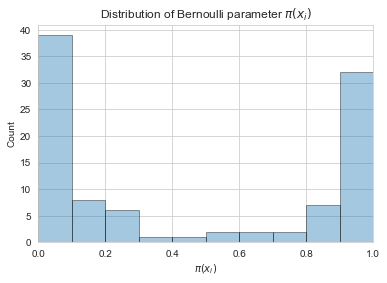

In [3]:
# plot Bernoulli parameter distribution
sns.set_style('whitegrid')
sns.distplot(pis, hist_kws={'edgecolor': 'black'}, kde=False, bins=10)
plt.xlim(0.0, 1.0)
plt.xlabel('$\pi(x_i)$')
plt.ylabel('Count')
plt.title('Distribution of Bernoulli parameter $\pi(x_i)$')
plt.show()

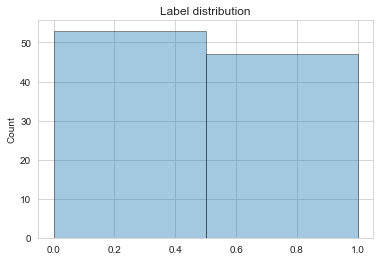

In [4]:
# plot label distribution
sns.distplot(y, hist_kws={'edgecolor': 'black'}, kde=False, bins=2)
plt.ylabel('Count')
plt.title('Label distribution')
plt.show()

Now, let's test how well logistic regression can predict the outcome.

In [5]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=seed, penalty='l1', solver='liblinear')
clf.fit(X_train, y_train)
print('Sklearn train accuracy: {:.3f}'.format(clf.score(X_train, y_train)))
print('Sklearn test accuracy: {:.3f}'.format(clf.score(X_test, y_test)))

Sklearn train accuracy: 1.000
Sklearn test accuracy: 0.750


In [6]:
params_map = {
    'learning_rate': [1e-2],
    'batch_size': [50],
    'num_epochs': [200],
    'l1_penalty': [0.01]
}

torch_model = TorchLR(params_map, seed=2)
losses, preds, preds_bn = torch_model.train_torch_model(X_train, X_test, y_train, y_test, save_weights=True)
y_pred_train, y_pred_test = preds_bn
print('Torch train accuracy: {:.3f}'.format(TorchLR.calculate_accuracy(y_train, y_pred_train.flatten())))
print('Torch test accuracy: {:.3f}'.format(TorchLR.calculate_accuracy(y_test, y_pred_test.flatten())))

Torch train accuracy: 1.000
Torch test accuracy: 0.800


In [7]:
torch_coefs = torch_model.last_weights.flatten()
close_to_zero = (np.abs(torch_coefs) < (np.abs(torch_coefs).max() / 100))
torch_coefs[close_to_zero] = 0
sk_jaccard = compute_jaccard(np.where(~is_correlated)[0], np.where(clf.coef_.flatten() == 0)[0])
torch_jaccard = compute_jaccard(np.where(~is_correlated)[0], np.where(torch_coefs == 0)[0])
print('Scikit coefficient Jaccard similarity: {:.3f} ({}/{})'.format(*sk_jaccard))
print('Torch coefficient Jaccard similarity: {:.3f} ({}/{})'.format(*torch_jaccard))

Scikit coefficient Jaccard similarity: 0.261 (6/23)
Torch coefficient Jaccard similarity: 0.231 (3/13)


In [8]:
print(clf.coef_.flatten())
print(torch_coefs)
print(is_correlated)

[ 0.          0.00561532  0.63665448  0.79017739  0.          0.48735013
  0.52748196  0.          0.          0.          0.         -0.27271956
  0.28521736  0.          0.1678756   0.83347183 -1.12745241  0.28539915
  1.01967204 -0.28463517 -0.57723483  0.         -0.9810943   0.09111503
  0.          0.7821279   0.          0.         -0.02637163 -0.01375479
 -0.26386854 -0.02680161  0.          0.          0.          0.
 -0.3173497   0.32135748  0.          0.          0.06495134  0.
  0.96492023  0.49394279 -0.66525054  0.13522675  0.          0.6474743
  0.1355675   1.22771304]
[-0.03001145  0.11383027  0.56309426  0.47990125  0.23711503  0.44658142
  0.4717514  -0.03001292  0.          0.01476102 -0.08545631 -0.30354947
  0.49044025  0.          0.28106296  0.46578026 -0.7857805   0.42172015
  0.56917423 -0.4246671  -0.3845011   0.16215384 -0.5865089   0.26139238
  0.          0.46439183  0.          0.         -0.10306269 -0.2610396
 -0.16909042 -0.15716144 -0.03181732  0.   

## Experiments

We want to look at:

* Accuracy: How well can we predict the outcome from the features?
* Feature selection: How well can we predict which features are uncorrelated with the outcome?

In these experiments, we record the above for varying dataset shapes (tall, square-ish, wide) and varying numbers of features that are uncorrelated with the outcome.

In [15]:
# one tall dataset (n > p), one square dataset (n = p), one wide dataset (n < p)
dataset_sizes = {
    'tall': (1000, 20), 
    'square': (1000, 1000),
    'wide': (1000, 10000)
}
uncorr_fracs = [0.0, 0.2, 0.5, 0.8]

# just keep this constant for now, 0.8/0.2 train/test split
train_frac = 0.8

results = []

for seed in range(5):
    for ds, (n, p) in dataset_sizes.items():
        for uncorr_frac in uncorr_fracs:
        
            # generate data with given parameters
            X, y, _, is_correlated = ll.simulate_ll(n, p, uncorr_frac, seed=seed)
            train_ixs = ll.split_train_test(n, train_frac, seed=seed)
            X_train, X_test = X[train_ixs], X[~train_ixs]
            y_train, y_test = y[train_ixs], y[~train_ixs]

            # fit sklearn classifier
            clf = LogisticRegression(random_state=seed, penalty='l1', solver='liblinear')
            clf.fit(X_train, y_train)
            sk_train_acc = clf.score(X_train, y_train)
            sk_test_acc = clf.score(X_test, y_test)

            # fit torch classifier
            torch_model = TorchLR(params_map, seed=seed)        
            _, __, preds_bn = torch_model.train_torch_model(X_train, X_test, y_train, y_test,
                                                            save_weights=True)
            torch_train_acc = TorchLR.calculate_accuracy(y_train, preds_bn[0].flatten())
            torch_test_acc = TorchLR.calculate_accuracy(y_test, preds_bn[1].flatten())
            
            # random prediction baseline
            random_preds_train = (np.random.uniform(size=len(y_train)) > 0.5).astype('int')
            random_preds_test = (np.random.uniform(size=len(y_test)) > 0.5).astype('int')
            random_train_acc = TorchLR.calculate_accuracy(y_train, random_preds_train)
            random_test_acc = TorchLR.calculate_accuracy(y_test, random_preds_test)

            # calculate coefficient overlap
            torch_coefs = torch_model.last_weights.flatten()
            close_to_zero = (np.abs(torch_coefs) < (np.abs(torch_coefs).max() / 1000))
            torch_coefs[close_to_zero] = 0
            
            # select random coefficients to zero out as a baseline
            # just select the same number of zeros as the torch coefficients for now
            random_coefs = np.ones(torch_coefs.shape)
            random_coefs[:np.count_nonzero(torch_coefs == 0)] = 0
            np.random.shuffle(random_coefs)
            
            sk_jaccard = compute_jaccard(np.where(~is_correlated)[0], np.where(clf.coef_.flatten() == 0)[0])
            torch_jaccard = compute_jaccard(np.where(~is_correlated)[0], np.where(torch_coefs == 0)[0])
            random_jaccard = compute_jaccard(np.where(~is_correlated)[0], np.where(random_coefs == 0)[0])

            results.append([seed, ds, uncorr_frac, 'sklearn', sk_train_acc, sk_test_acc, sk_jaccard[0]])
            results.append([seed, ds, uncorr_frac, 'torch', torch_train_acc, torch_test_acc, torch_jaccard[0]])
            results.append([seed, ds, uncorr_frac, 'random', random_train_acc, random_test_acc, random_jaccard[0]])
        
results_df = pd.DataFrame(results, columns=['seed', 'dataset', 'uncorr_frac', 'imp', 'train_acc', 'test_acc', 'coef_sim'])
results_df.head()

,seed,dataset,uncorr_frac,imp,train_acc,test_acc,coef_sim
0,0,tall,0.0,sklearn,0.85875,0.825,0.0
1,0,tall,0.0,torch,0.86000,0.830,0.0
2,0,tall,0.0,random,0.50500,0.530,0.0
3,0,tall,0.2,sklearn,0.87125,0.855,0.0
4,0,tall,0.2,torch,0.87625,0.855,0.5


In [16]:
tall_df = results_df[results_df['dataset'] == 'tall']
tall_df.head(n=20)

,seed,dataset,uncorr_frac,imp,train_acc,test_acc,coef_sim
0,0,tall,0.0,sklearn,0.85875,0.825,0.000000
1,0,tall,0.0,torch,0.86000,0.830,0.000000
2,0,tall,0.0,random,0.50500,0.530,0.000000
3,0,tall,0.2,sklearn,0.87125,0.855,0.000000
4,0,tall,0.2,torch,0.87625,0.855,0.500000
5,0,tall,0.2,random,0.49625,0.485,0.000000
6,0,tall,0.5,sklearn,0.83500,0.810,0.100000
7,0,tall,0.5,torch,0.83250,0.795,0.300000
8,0,tall,0.5,random,0.50125,0.525,0.181818
9,0,tall,0.8,sklearn,0.72125,0.690,0.062500


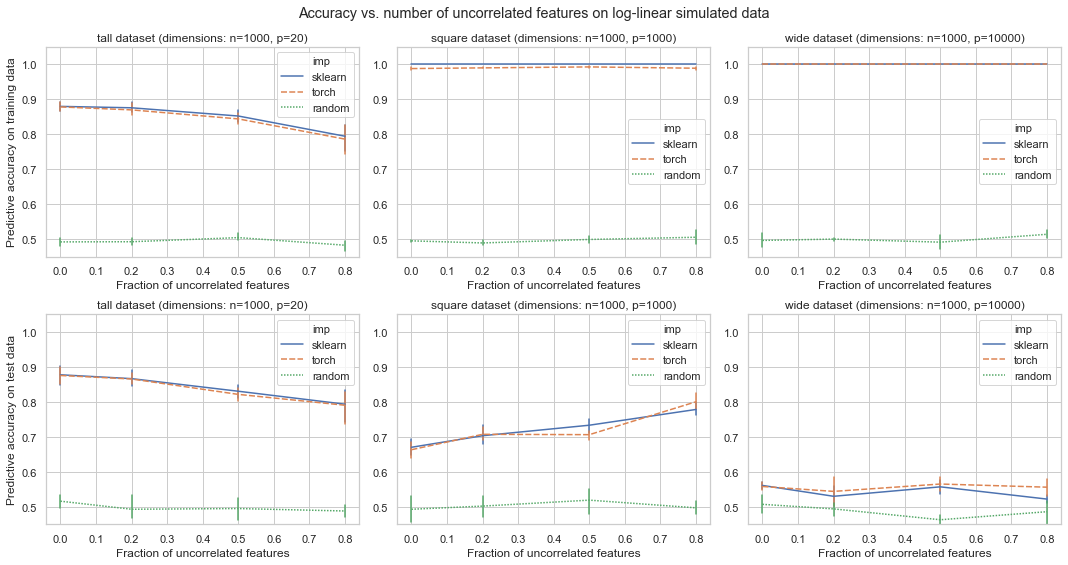

In [52]:
sns.set(style='whitegrid', rc={'figure.figsize': (15, 8)})
fig, axarr = plt.subplots(2, 3)
for ix, (dataset, (n, p)) in enumerate(dataset_sizes.items()):
    ax1 = axarr[0, ix]
    data_df = results_df[results_df['dataset'] == dataset]
    sns.set_style('whitegrid')
    sns.lineplot(data=data_df, x='uncorr_frac', y='train_acc', err_style='bars', style='imp', hue='imp', ax=ax1)
    ax1.set_xlabel('Fraction of uncorrelated features')
    ax1.set_ylim(0.45, 1.05)
    if ix == 0:
        ax1.set_ylabel('Predictive accuracy on training data')
    else:
        ax1.set_ylabel('')
    ax1.set_title('{} dataset (dimensions: n={}, p={})'.format(dataset, n, p))
    ax2 = axarr[1, ix]
    data_df = results_df[results_df['dataset'] == dataset]
    sns.set_style('whitegrid')
    sns.lineplot(data=data_df, x='uncorr_frac', y='test_acc', err_style='bars', style='imp', hue='imp', ax=ax2)
    ax2.set_xlabel('Fraction of uncorrelated features')
    ax2.set_ylim(0.45, 1.05)
    if ix == 0:
        ax2.set_ylabel('Predictive accuracy on test data')
    else:
        ax2.set_ylabel('')
    ax2.set_title('{} dataset (dimensions: n={}, p={})'.format(dataset, n, p))
plt.tight_layout()
fig.suptitle('Accuracy vs. number of uncorrelated features on log-linear simulated data')
fig.subplots_adjust(top=0.91)
plt.show()

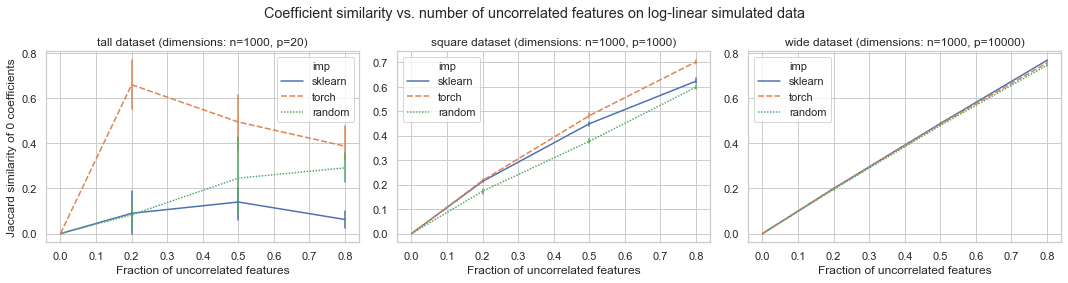

In [47]:
sns.set(style='whitegrid', rc={'figure.figsize': (15, 4)})
fig, axarr = plt.subplots(1, 3)
for ix, (dataset, (n, p)) in enumerate(dataset_sizes.items()):
    ax = axarr[ix]
    data_df = results_df[results_df['dataset'] == dataset]
    sns.set_style('whitegrid')
    sns.lineplot(data=data_df, x='uncorr_frac', y='coef_sim', err_style='bars', style='imp', hue='imp', ax=ax)
    ax.set_xlabel('Fraction of uncorrelated features')
    if ix == 0:
        ax.set_ylabel('Jaccard similarity of 0 coefficients')
    else:
        ax.set_ylabel('')
    ax.set_title('{} dataset (dimensions: n={}, p={})'.format(dataset, n, p))
fig.suptitle('Coefficient similarity vs. number of uncorrelated features on log-linear simulated data')
plt.tight_layout()
fig.subplots_adjust(top=0.825)
plt.show()

We also want to test if adding collinearity makes it harder to find the features that are truly correlated with the outcome. It seems like this should be trivially true, since it should be impossible for the model to tell which features are just duplicates (or linear combinations) of the other features.

Here, we just duplicate a subset of the features - later we could test scaling them in different ways, etc.

In [9]:
# same parameters as earlier experiments, but also vary number of duplicated features
dataset_sizes = {
    'tall': (1000, 20), 
    'square': (1000, 1000),
    'wide': (1000, 10000)
}
uncorr_fracs = [0.0, 0.2, 0.5, 0.8]
train_frac = 0.8
results = []

duplicate_fracs = [0.0, 0.1, 0.2, 0.5, 1.0]

for seed in range(5):
    for ds, (n, p) in dataset_sizes.items():
        for dup_frac in duplicate_fracs:
            
            num_duplicates = int(p * dup_frac)
            
            for uncorr_frac in uncorr_fracs:

                # generate data with given parameters
                X, y, _, is_correlated = ll.simulate_ll(n, p, uncorr_frac,
                                                        duplicate_features=num_duplicates,
                                                        seed=seed)
                train_ixs = ll.split_train_test(n, train_frac, seed=seed)
                X_train, X_test = X[train_ixs], X[~train_ixs]
                y_train, y_test = y[train_ixs], y[~train_ixs]

                # fit sklearn classifier
                clf = LogisticRegression(random_state=seed, penalty='l1', solver='liblinear')
                clf.fit(X_train, y_train)
                sk_train_acc = clf.score(X_train, y_train)
                sk_test_acc = clf.score(X_test, y_test)

                # fit torch classifier
                torch_model = TorchLR(params_map, seed=seed)        
                _, __, preds_bn = torch_model.train_torch_model(X_train, X_test, y_train, y_test,
                                                                save_weights=True)
                torch_train_acc = TorchLR.calculate_accuracy(y_train, preds_bn[0].flatten())
                torch_test_acc = TorchLR.calculate_accuracy(y_test, preds_bn[1].flatten())

                # random prediction baseline
                random_preds_train = (np.random.uniform(size=len(y_train)) > 0.5).astype('int')
                random_preds_test = (np.random.uniform(size=len(y_test)) > 0.5).astype('int')
                random_train_acc = TorchLR.calculate_accuracy(y_train, random_preds_train)
                random_test_acc = TorchLR.calculate_accuracy(y_test, random_preds_test)

                # calculate coefficient overlap
                torch_coefs = torch_model.last_weights.flatten()
                close_to_zero = (np.abs(torch_coefs) < (np.abs(torch_coefs).max() / 1000))
                torch_coefs[close_to_zero] = 0

                # select random coefficients to zero out as a baseline
                # just select the same number of zeros as the torch coefficients for now
                random_coefs = np.ones(torch_coefs.shape)
                random_coefs[:np.count_nonzero(torch_coefs == 0)] = 0
                np.random.shuffle(random_coefs)

                sk_jaccard = compute_jaccard(np.where(~is_correlated)[0], np.where(clf.coef_.flatten() == 0)[0])
                torch_jaccard = compute_jaccard(np.where(~is_correlated)[0], np.where(torch_coefs == 0)[0])
                random_jaccard = compute_jaccard(np.where(~is_correlated)[0], np.where(random_coefs == 0)[0])

                results.append([seed, ds, uncorr_frac, num_duplicates, 'sklearn', sk_train_acc, sk_test_acc, sk_jaccard[0]])
                results.append([seed, ds, uncorr_frac, num_duplicates, 'torch', torch_train_acc, torch_test_acc, torch_jaccard[0]])
                results.append([seed, ds, uncorr_frac, num_duplicates, 'random', random_train_acc, random_test_acc, random_jaccard[0]])
        
results_df = pd.DataFrame(results, columns=['seed', 'dataset', 'uncorr_frac', 'num_duplicates', 
                                            'imp', 'train_acc', 'test_acc', 'coef_sim'])
results_df.head()

,seed,dataset,uncorr_frac,num_duplicates,imp,train_acc,test_acc,coef_sim
0,0,tall,0.0,0,sklearn,0.85875,0.825,0.0
1,0,tall,0.0,0,torch,0.86000,0.830,0.0
2,0,tall,0.0,0,random,0.50500,0.530,0.0
3,0,tall,0.2,0,sklearn,0.87125,0.855,0.0
4,0,tall,0.2,0,torch,0.87625,0.855,0.5


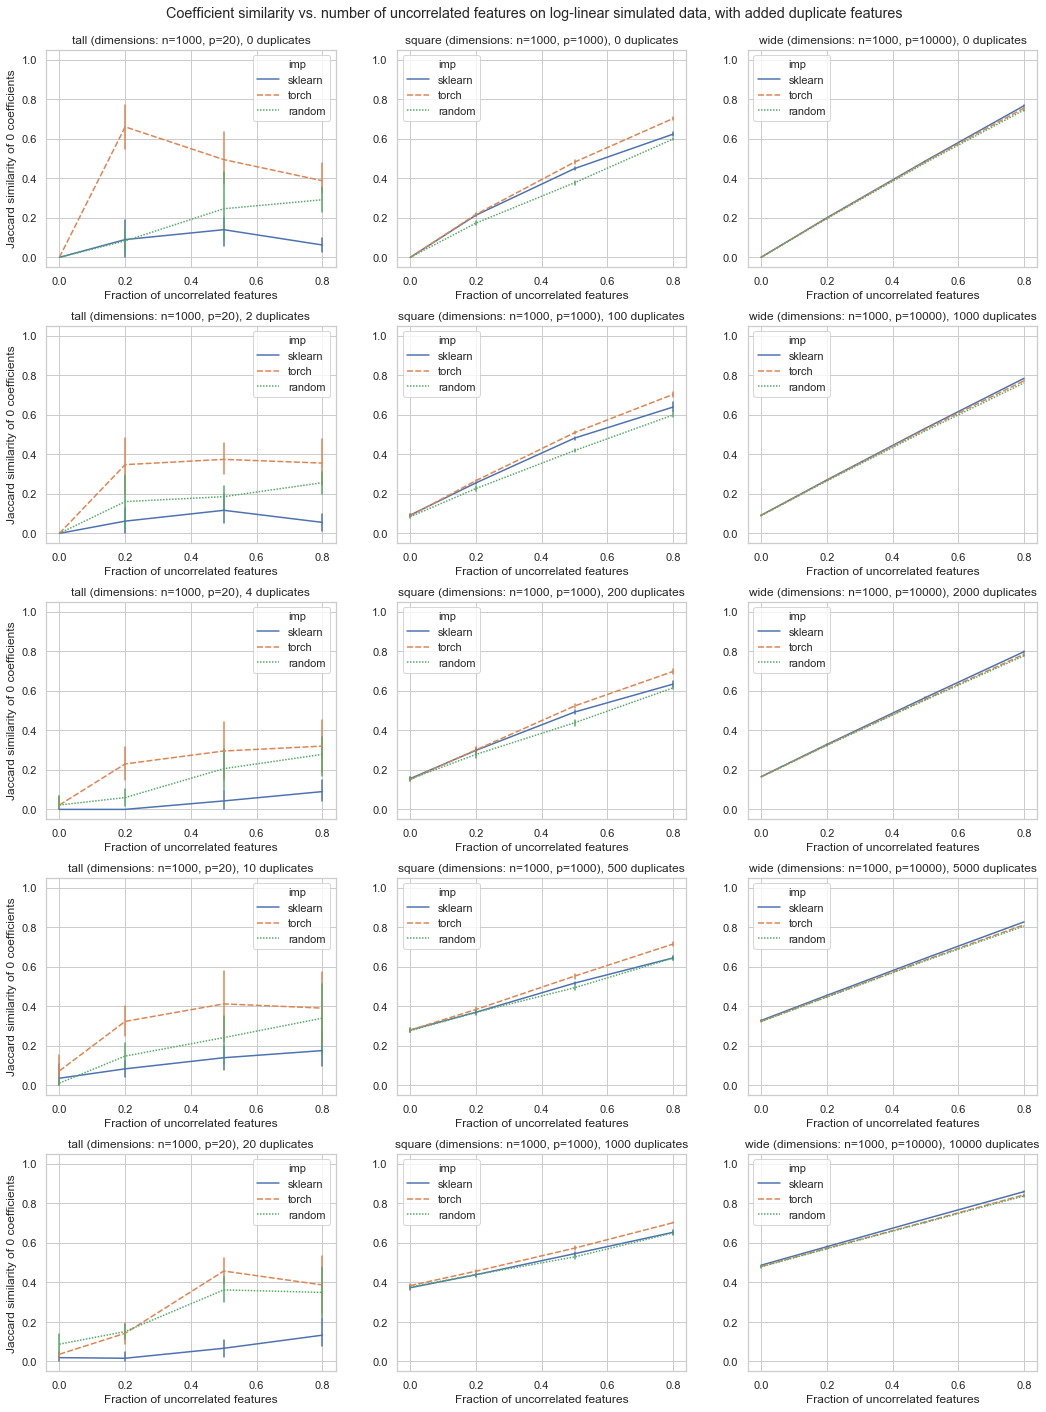

In [19]:
sns.set(style='whitegrid', rc={'figure.figsize': (15, 20)})
fig, axarr = plt.subplots(5, 3)
duplicate_fracs = [0.0, 0.1, 0.2, 0.5, 1.0]

for ix1, dup_frac in enumerate(duplicate_fracs):
    for ix2, (dataset, (n, p)) in enumerate(dataset_sizes.items()):
        ax = axarr[ix1, ix2]
        num_dups = int(p * dup_frac)
        data_df = results_df[(results_df['num_duplicates'] == num_dups) &
                             (results_df['dataset'] == dataset)]
        sns.set_style('whitegrid')
        sns.lineplot(data=data_df, x='uncorr_frac', y='coef_sim', err_style='bars', style='imp', hue='imp', ax=ax)
        ax.set_xlabel('Fraction of uncorrelated features')
        if ix2 == 0:
            ax.set_ylabel('Jaccard similarity of 0 coefficients')
        else:
            ax.set_ylabel('')
        ax.set_ylim(-0.05, 1.05)
        ax.set_title('{} (dimensions: n={}, p={}), {} duplicates'.format(dataset, n, p, num_dups))
fig.suptitle('Coefficient similarity vs. number of uncorrelated features on log-linear simulated data, '
             'with added duplicate features')
plt.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()